In [1]:
from datetime import datetime

import numpy as np
import torch
import torch.nn.functional as F
import skimage.io
import skimage.transform
from PIL import Image
import matplotlib.pyplot as plt
from art.utils import load_mnist
from art.estimators.classification import TensorFlowClassifier
from art.metrics.metrics import clever_t, clever_u, clever
import tensorflow as tf

# Load data

In [2]:
image = Image.open('../artifacts/data/cherry.jpg')

In [3]:
image.size

(100, 100)

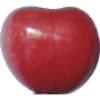

In [4]:
image

# Load model 

In [5]:
output_node_name = 'loss:0'
input_node_name = 'Placeholder:0'

In [6]:
def load_graph(path):
    tf.compat.v1.reset_default_graph()
    
    graph_def = tf.compat.v1.GraphDef()
    with open(path, 'rb') as f:
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='')   
        
    return graph_def

In [7]:
model_path = '../artifacts/models/customvision_model_tf/model.pb'

In [8]:
graph_def = load_graph(model_path)

In [9]:
with tf.compat.v1.Session() as sess:
    input_tensor = sess.graph.get_tensor_by_name(input_node_name)
    output_tensor = sess.graph.get_tensor_by_name(output_node_name)
    
    input_shape = input_tensor.shape.as_list()[1:-1]

In [10]:
input_shape

[224, 224]

## Resize image

In [24]:
image_resized = image.resize(input_shape)

In [25]:
image_resized.size

(224, 224)

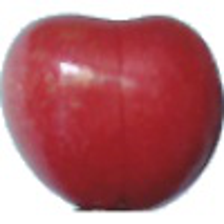

In [26]:
image_resized

# Run prediction

In [27]:
image_tensor = np.array(image_resized)

In [28]:
tf.compat.v1.reset_default_graph()
tf.import_graph_def(graph_def, name='')

with tf.compat.v1.Session() as sess:
    prob_tensor = sess.graph.get_tensor_by_name(output_node_name)
    input_tensor = sess.graph.get_tensor_by_name(input_node_name)
    predictions, = sess.run(prob_tensor, {input_tensor: [image_tensor] })

In [29]:
predictions

array([0.03115423, 0.05316554, 0.00157638, 0.29439414, 0.4087754 ,
       0.04284546, 0.00687267, 0.0396805 , 0.00174122, 0.007713  ,
       0.01669133, 0.01349894, 0.08189126], dtype=float32)

In [30]:
predictions.argmax()

4

# Create ART classifier and calc CLEVER

In [34]:
R_L1 = 40
R_L2 = 2
R_LI = 0.1

In [38]:
with tf.compat.v1.Session() as sess:
    prob_tensor = sess.graph.get_tensor_by_name(output_node_name)
    input_tensor = sess.graph.get_tensor_by_name(input_node_name)

    classifier = TensorFlowClassifier(input_tensor, prob_tensor, sess=sess)
    
    # Test targeted clever
    res0 = clever_t(classifier, image_tensor.astype(np.float32), 2, 10, 5, R_L1, norm=1, pool_factor=3)
    res1 = clever_t(classifier, image_tensor.astype(np.float32), 2, 10, 5, R_L2, norm=2, pool_factor=3)
    res2 = clever_t(classifier, image_tensor.astype(np.float32), 2, 10, 5, R_LI, norm=np.inf, pool_factor=3)
    print(f'Targeted: {res0:.3f}, {res1:.3f}, {res2:.3f}')    
    
    # Test untargeted clever
    res0 = clever_u(classifier, image_tensor.astype(np.float32), 10, 5, R_L1, norm=1, pool_factor=3)
    res1 = clever_u(classifier, image_tensor.astype(np.float32), 10, 5, R_L2, norm=2, pool_factor=3)
    res2 = clever_u(classifier, image_tensor.astype(np.float32), 10, 5, R_LI, norm=np.inf, pool_factor=3)
    print(f'Untargeted: {res0:.3f}, {res1:.3f}, {res2:.3f}')    

Targeted: 40.000, 2.000, 0.100



Untargeted: 40.000, 2.000, 0.028
